## Ziel der Challenge
Erstellen einer Vorhersage für alle Serien der Competition über 28 Tage



### Daten 

Besonderheiten:
- Die Daten sind gruppiert und umfassen den Absatz von 3049 Produkten, Klassifiziert nach 3 Kategorien (Hobbies, Foods and Household) und 7 Product Departments. Die Produkte werden in 10 Stores in den Staaten CA, TX und WI verkauft.
- Zusätzlich zu den Zeitreihen gibt es im Datensatz weitere Informationen, wie den Wochentag, den Verkaufspreis, Events, etc. die die Verkaufszahlen beeinflussen können.
- Zeitraum der Daten: 2011-01-29 bis 2016-06-19 (entspricht 1.941 Tagen / 5,4 Jahren)

Der M5 Datensatz besteht aus 4 Dateien:

1. calendar.csv: Informationen zum Datum, an dem die Produkte verkauft wurden. Informationen zu Events sind in den Spalten event_1 und event_2 enthalten. In den Spalten snap_(WI|TY|CA) ist vermerkt, ob an diesem Tag SNAP-Kauf erlaubt ist.
2. sell_prices.csv: Enthält Informationen zum Preis eines Produkts nach Store, Produkt und Woche. 
3. sales_train_validation.csv: Historische Verkaufsdaten gruppiert nach Produkt, Department, Kategorie, State und Store. (von d_1 bis d_1913)
4. sales_train_evaluation.csv: Historische Verkaufsdaten gruppiert nach Produkt, Department, Kategorie, State und Store. (von d_1 bis d_1941)

### Evaluierung
Die Perfomanz wird für jede Serie einzeln mit dem RMSSE berechnet und dann der WRMSSE über die kompletten Zeitreihen ermittelt.


# Exploratory Data Analytics (EDA)

## Vorbereitung der Daten

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)

if IN_COLAB:
  from google.colab import files

  uploaded = files.upload()
  calendar = pd.read_csv(io.BytesIO(uploaded['calendar.csv']))

  uploaded = files.upload()
  sales = pd.read_csv(io.BytesIO(uploaded['sales_train_evaluation.zip']), compression="zip")

  uploaded = files.upload()
  prices = pd.read_csv(io.BytesIO(uploaded['sell_prices.zip']), compression="zip")
else  :
  calendar=pd.read_csv('../data/calendar.csv')
  sales=pd.read_csv('../data/sales_train_evaluation.csv')
  prices=pd.read_csv('../data/sell_prices.csv')

running in Colab: True


Saving calendar.csv to calendar (6).csv


Saving sales_train_evaluation.zip to sales_train_evaluation (5).zip


Saving sell_prices.csv to sell_prices.csv


KeyboardInterrupt: ignored

Im folgenden findet ein "downcasting" der Dataframes statt. Hierdurch soll der Speiecherplatz, der von diesen benötigt wird, reduziert werden. Zudem können hierdurch die Operationen, die auf den Dataframes ausgeführt werden, verschnellert werden.

In [7]:
#Quelle: https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling/notebook#2.-Downcasting
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [8]:
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

## Analyse der einzelnen Dateien

### Sales 

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
sales.shape

(30490, 1947)

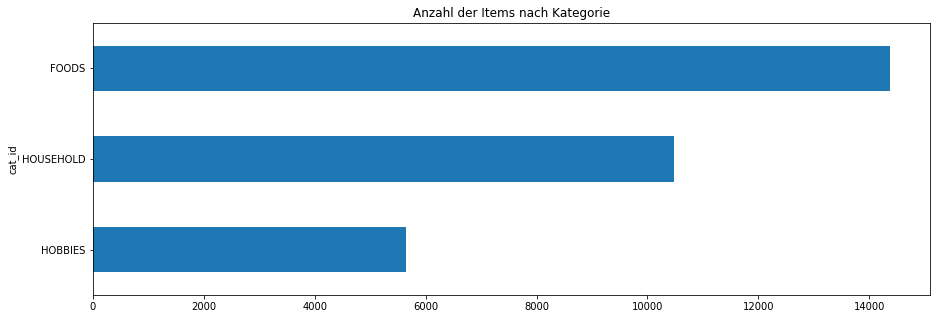

In [ ]:
sales.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Anzahl der Items nach Kategorie')
plt.show()

#### Absatz eines ausgewählten Datensatzes

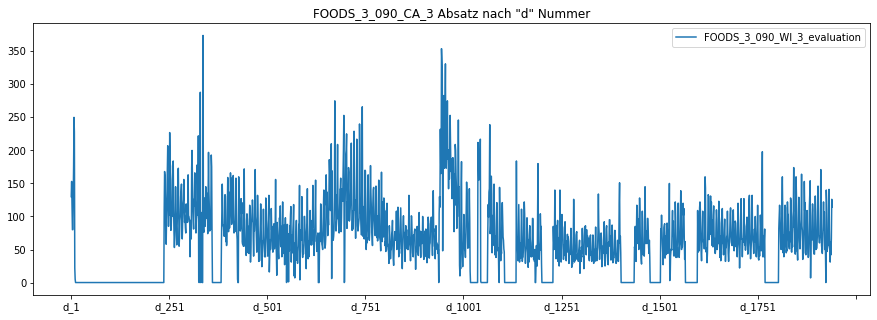

In [ ]:
d_cols = [c for c in sales.columns if 'd_' in c]

sales.loc[sales['id'] == 'FOODS_3_090_WI_3_evaluation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 Absatz nach "d" Nummer')
plt.legend()
plt.show()

### Calendar

In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


Im folgenden wird das Datum aus dem Calendar Datensatz zum Absatz-Sample hinzugefügt

In [ ]:
example = sales.loc[sales['id'] == 'FOODS_3_090_WI_3_evaluation'][d_cols].T
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.rename(columns={29755:'FOODS_3_090_CA_3'})
example = example.merge(calendar)
example.head()

,d,FOODS_3_090_CA_3,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,130,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,153,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,119,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,80,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,80,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


#### Absatz eines ausgewählten Datensatzes nach Datum

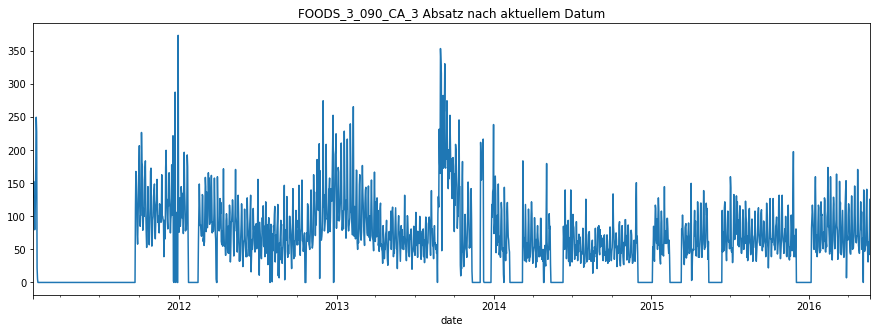

In [ ]:
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 Absatz nach aktuellem Datum')
plt.show()

## Preis

In [ ]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


Mit Preis und Absatz kann nun der Umsatz pro Kalendertag berechnet werden. Dies kann durch ein Join mit der Price-Tabelle erreicht werden. 

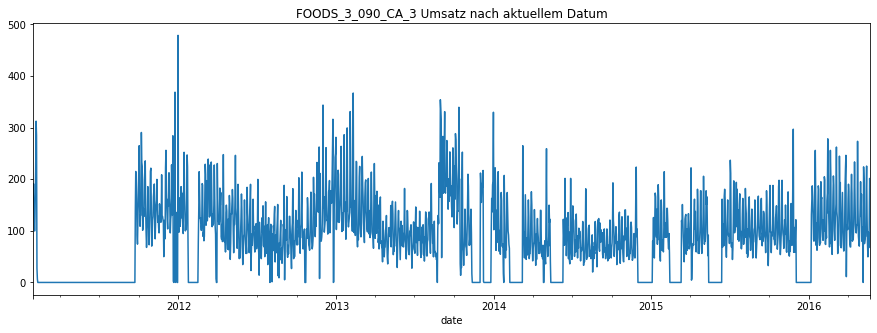

In [ ]:
example2 = example.merge(prices[(prices['store_id']=='CA_3') & (prices['item_id']=='FOODS_3_090')])
example2['FOODS_3_090_CA_3_sales'] = example2['FOODS_3_090_CA_3'] * example2['sell_price']

example2.set_index('date')['FOODS_3_090_CA_3_sales'] \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 Umsatz nach aktuellem Datum')
plt.show()

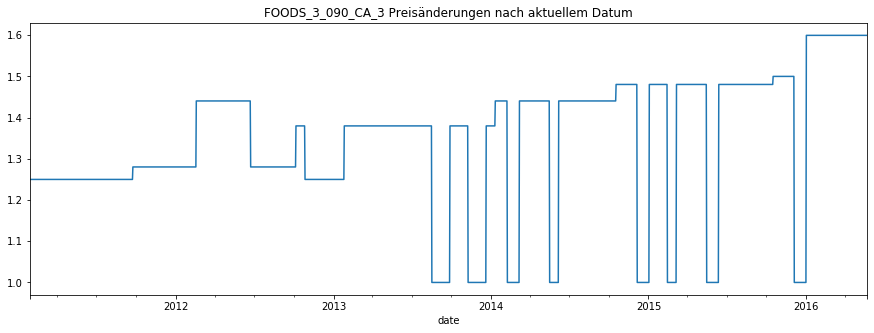

In [ ]:
example2 = example.merge(prices[(prices['store_id']=='CA_3') & (prices['item_id']=='FOODS_3_090')])
example2['FOODS_3_090_CA_3_sales'] = example2['FOODS_3_090_CA_3'] * example2['sell_price']

example2.set_index('date')['sell_price'] \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 Preisänderungen nach aktuellem Datum')
plt.show()

## Überblick

### Aggregierte Sales-Daten nach Zeit

Die Daten werden im folgenden in einen Datensatz überführt. Hierzu werden die Sales-Daten zuerst mit der Funktion "melt" in eine andere Form überführt und anschließend mit den Calendar- und Preis-Daten zusammengeführt.

In [10]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [11]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
del sales
del calendar
del prices
gc.collect()

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(1), int16(3), int8(5

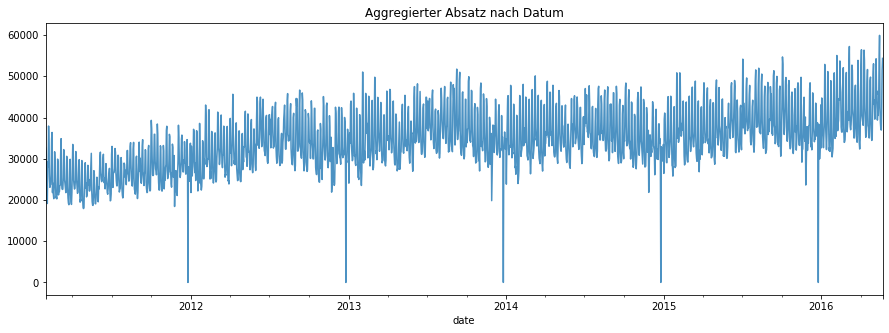

In [ ]:
df.groupby(by=['date'])['sold'].sum().plot(figsize=(15, 5),
              alpha=0.8,
              title='Aggregierter Absatz nach Datum')
plt.show()

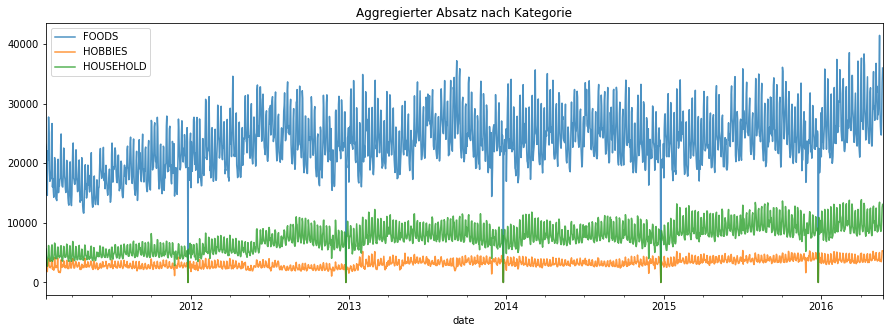

In [ ]:
for index, group in df.groupby(by=['cat_id']):
    group_agg = group.groupby(['date'])['sold'].sum()
    group_agg.plot(figsize=(15, 5),
              alpha=0.8,
              label=index,
              title='Aggregierter Absatz nach Kategorie')
plt.legend()
plt.show()

Insgesamt gibt es drei Produktkategorien:
- Haushalt (Household)
- Hobbys (Hobbies)
- Nahrungsmittel (Foods)

Die Nahrungsmittel haben bei Walmart mit Abstand den höchsten Absatz. 

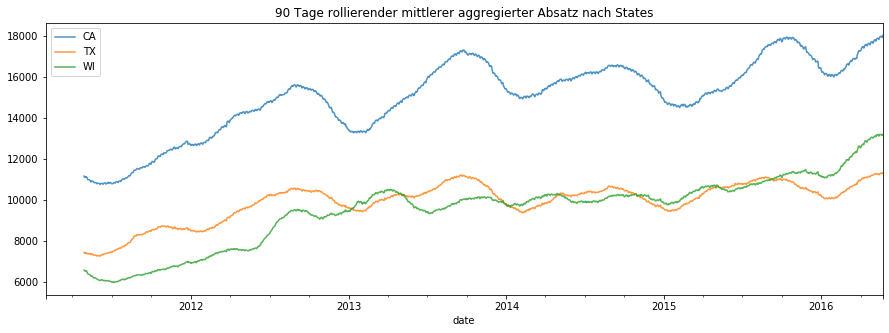

In [ ]:
for index, group in df.groupby(by=['state_id']):
    group_agg = group.groupby(['date'])['sold'].sum().rolling(90).mean()
    group_agg.plot(figsize=(15, 5),
              alpha=0.8,
              label=index,
              title='90 Tage rollierender mittlerer aggregierter Absatz nach States')
plt.legend()
plt.show()

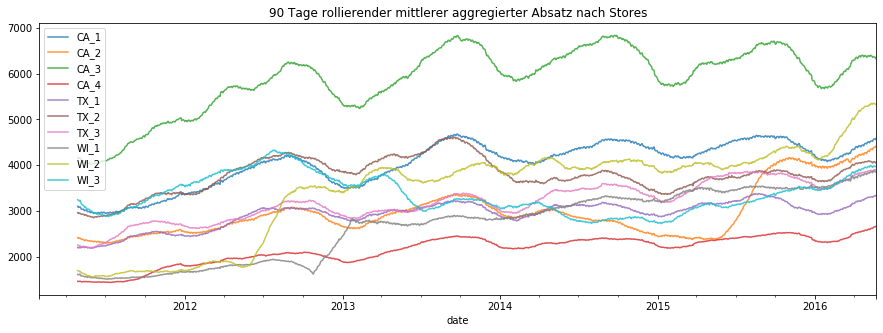

In [ ]:
for index, group in df.groupby(by=['store_id']):
    group_agg = group.groupby(['date'])['sold'].sum().rolling(90).mean()
    group_agg.plot(figsize=(15, 5),
              alpha=0.8,
              label=index,
              title='90 Tage rollierender mittlerer aggregierter Absatz nach Stores')
plt.legend()
plt.show()

Im Datensatz sind die mittleren Absätze innerhalb von 90 Tagen von 10 Märkten in 3 unterschiedlichen Bundesstaaten aufgeführt. Die Höhe der Absätze unterscheiden sich stark unter den einzelnen Märkten.

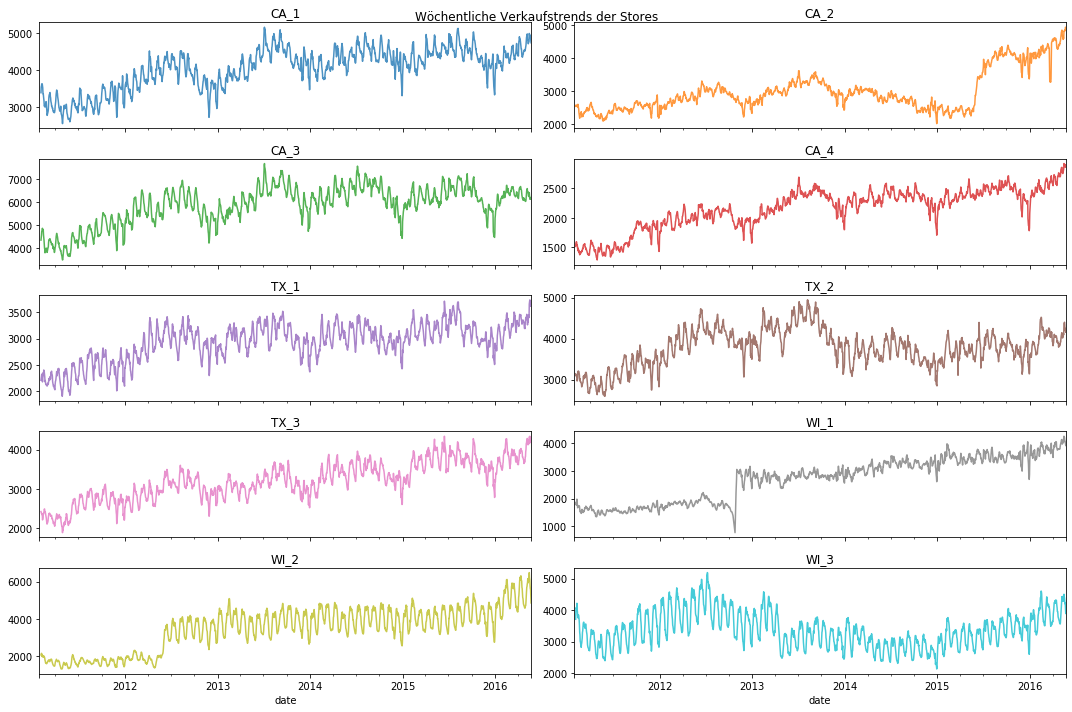

In [ ]:
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

for index, group in df.groupby(by=['store_id']):
    group_agg = group.groupby(['date'])['sold'].sum().rolling(7).mean()
    group_agg.plot(alpha=0.8,
                  ax=axes[ax_idx],
                  title=index,
                  label=index,
                  color=next(color_cycle))     
    ax_idx = ax_idx +1
plt.suptitle('Wöchentliche Verkaufstrends der Stores')
plt.tight_layout()
plt.show()

### Wöchentliche und monatliche Saisonalität

In [ ]:
salesPerWday = df.sort_values('wday').groupby(by=['month', 'wday'])['sold'].sum().unstack()

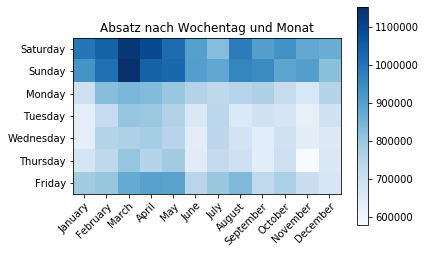

In [ ]:
daysInWeek = calendar[['wday', 'weekday']].sort_values('wday')['weekday'].unique()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots()
heatmap = ax.imshow(salesPerWday.T, cmap=plt.cm.Blues)

# We want to show all ticks...
ax.set_yticks(np.arange(len(daysInWeek)))
ax.set_xticks(np.arange(len(months)))
# ... and label them with the respective list entries
ax.set_yticklabels(daysInWeek)
ax.set_xticklabels(months)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.colorbar(heatmap)
plt.title('Absatz nach Wochentag und Monat')
plt.show()

Am Wochenende (Freitag, Samstag und Sonntag) ist der Absatz im ganzen Jahr am höchsten. Im Unterschied zu Deutschland haben die Einkaufsläden in der USA auch am Sonntag geöffnet.

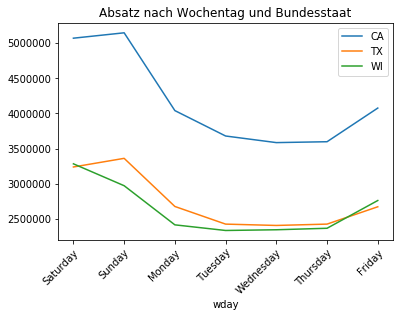

In [ ]:
salesPerWday = df.sort_values('wday').groupby(by=['wday', 'state_id'])['sold'].sum().unstack()

fig, ax = plt.subplots()
salesPerWday.plot(ax=ax)
ax.set_xticks(np.arange(start=1 , stop= 8))
ax.set_xticklabels(daysInWeek)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title('Absatz nach Wochentag und Bundesstaat')
plt.legend()
plt.show()

In allen Bundesstaaten nimmt der Absatz zum Wochenende stark zu. Der höchste Absatz ist in CA und TX am Sonntag zu verzeichnen. Im Gegensatz zu CA und TX ist in WI der Absatz am Samstag am höchsten. 

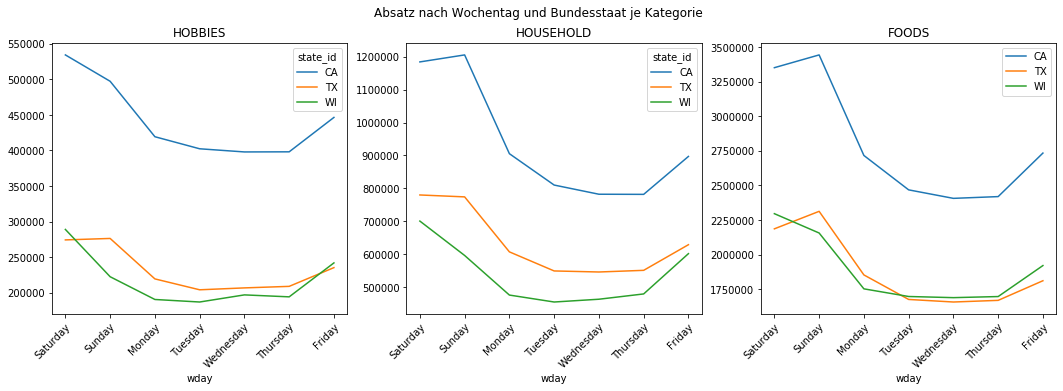

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 5))

i = 0
for cat in df['cat_id'].unique():
    salesPerWday = df[df['cat_id']==cat].sort_values('wday').groupby(by=['wday', 'state_id'])['sold'].sum().unstack()

    salesPerWday.plot(ax=ax[i], title=cat)
    ax[i].set_xticks(np.arange(start=1 , stop= 8))
    ax[i].set_xticklabels(daysInWeek)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    i= i + 1

fig.suptitle('Absatz nach Wochentag und Bundesstaat je Kategorie')
plt.legend()
plt.show()

In jeder Kategorie nehmen die Absätze zum Wochenende hin zu. 

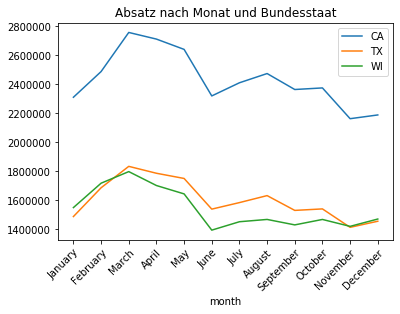

In [ ]:
salesPerMonth = df.sort_values('month').groupby(by=['month', 'state_id'])['sold'].sum().unstack()

fig, ax = plt.subplots()
salesPerMonth.plot(ax=ax)
ax.set_xticks(np.arange(start=1 , stop= 13))
ax.set_xticklabels(months)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.title('Absatz nach Monat und Bundesstaat')
plt.legend()
plt.show()

Die Summe der Absätze pro Monat ist nicht gleich. Der Absatz ist im Frühling (Februar, März, April) am höchsten und nimmt anschließend stark ab. Ein weiterer Höhepunkt ist im August zu verzeichnen. Der Trend lässt sich in allen Bundesstaaten nachvollziehen. 

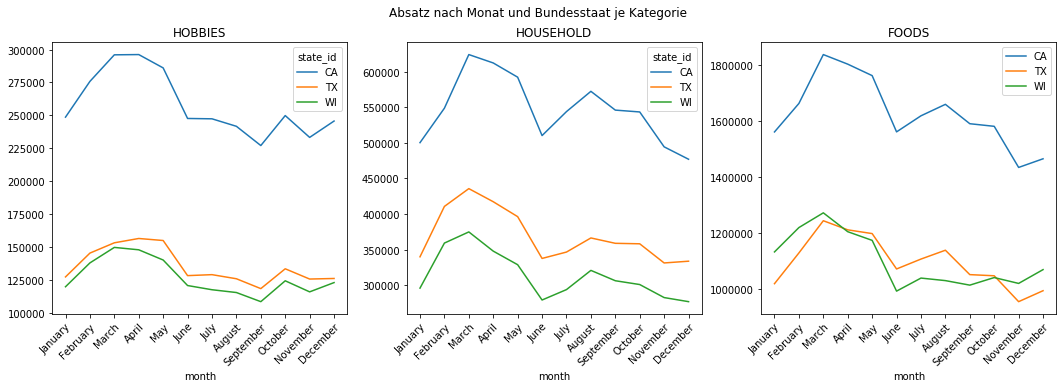

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 5))

i = 0
for cat in df['cat_id'].unique():
    salesPerMonth = df[df['cat_id']==cat].sort_values('month').groupby(by=['month', 'state_id'])['sold'].sum().unstack()

    salesPerMonth.plot(ax=ax[i], title=cat)
    ax[i].set_xticks(np.arange(start=1 , stop= 13))
    ax[i].set_xticklabels(months)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    i= i + 1

fig.suptitle('Absatz nach Monat und Bundesstaat je Kategorie')
plt.legend()
plt.show()

## Events

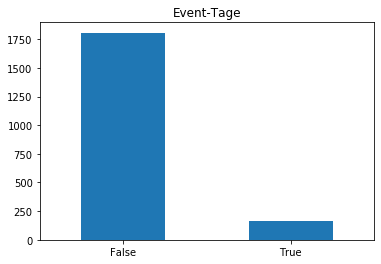

In [ ]:
((calendar['event_name_1'].notnull()) | (calendar['event_name_2'].notnull())).value_counts().plot.bar(rot=0, title='Event-Tage')

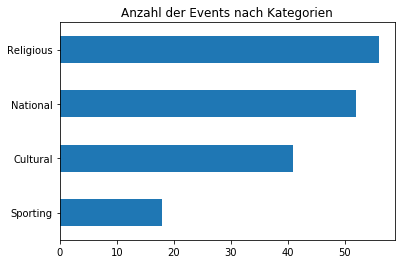

In [ ]:
event_type_list =  calendar['event_type_1'].value_counts().rename('event')
event_type_list = event_type_list.add(calendar['event_type_2'].value_counts().rename('event'), fill_value=0).sort_values()
event_type_list.plot.barh()
plt.title('Anzahl der Events nach Kategorien')
plt.show()

In [ ]:
print('List der Events mit Häufigkeit im Datensatz')
event_list = calendar['event_name_1'].value_counts().rename('event')
event_list = event_list.add(calendar['event_name_2'].value_counts().rename('event'), fill_value=0).sort_values()
event_list

List der Events mit Häufigkeit im Datensatz


Chanukah End           5.0
Thanksgiving           5.0
OrthodoxChristmas      5.0
NewYear                5.0
MartinLutherKingDay    5.0
LaborDay               5.0
IndependenceDay        5.0
Halloween              5.0
VeteransDay            5.0
EidAlAdha              5.0
Eid al-Fitr            5.0
Christmas              5.0
ColumbusDay            5.0
SuperBowl              6.0
StPatricksDay          6.0
Ramadan starts         6.0
Purim End              6.0
PresidentsDay          6.0
Pesach End             6.0
OrthodoxEaster         6.0
Cinco De Mayo          6.0
NBAFinalsStart         6.0
NBAFinalsEnd           6.0
Mother's day           6.0
ValentinesDay          6.0
Easter                 6.0
LentWeek2              6.0
LentStart              6.0
Father's day           6.0
MemorialDay            6.0
Name: event, dtype: float64

In [13]:
df['isEventDay'] = ((df['event_name_1'].notnull()) | (df['event_name_2'].notnull()))

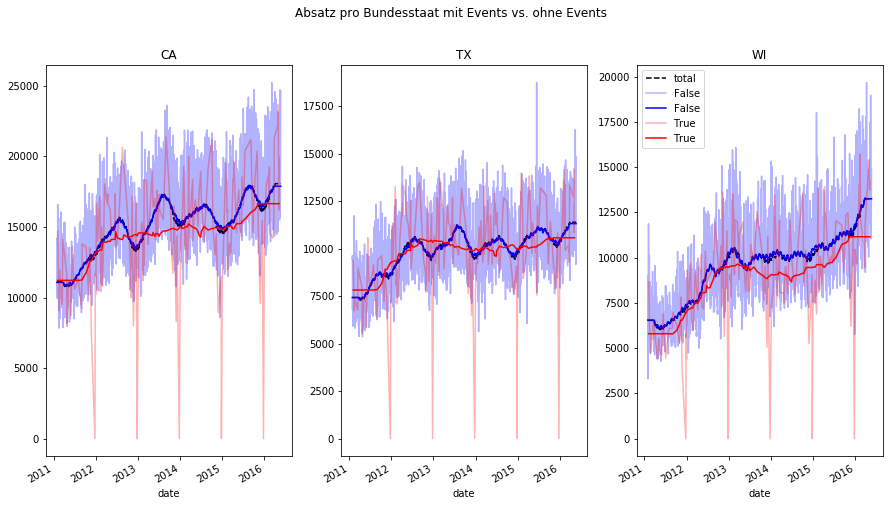

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
#from scipy import signal
fig, ax = plt.subplots(1,3, figsize=(15, 8))

i=0
for state in df['state_id'].unique():
    sales_state = df[df['state_id']==state].groupby(['date'])['sold'].sum()
    
    clf = KNeighborsRegressor(n_neighbors=100, weights='uniform', n_jobs=4)
    clf.fit(sales_state.index.values.reshape(-1, 1), sales_state.values.reshape(-1, 1))
    y_pred = clf.predict(sales_state.index.values.reshape(-1, 1))
    
    ax[i].plot(sales_state.index, np.concatenate(y_pred), alpha=1,
             color='black', label = 'total', linestyle='--')
    
    for index, group in df[df['state_id']==state].groupby(by=['isEventDay']):
        
        if index:
            n_neighbors = 30
            color = 'red'
        else :
            color = 'blue'
            n_neighbors = 100
            
        clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform', n_jobs=4)
            
        group_agg = group.groupby(['date'])['sold'].sum()
        group_agg.plot(
              alpha=0.3,
              title=state,
              ax=ax[i], color=color, label = index)
        
        #ax[i].plot(group_agg.index, signal.savgol_filter(group_agg.values, 151, 5), alpha=0.8,
             #color=color)
            
        clf.fit(group_agg.index.values.reshape(-1, 1), group_agg.values.reshape(-1, 1))
        y_pred = clf.predict(group_agg.index.values.reshape(-1, 1))
        ax[i].plot(group_agg.index, np.concatenate(y_pred), alpha=1,
             color=color, label = index)
        
    i = i +1
    
fig.suptitle('Absatz pro Bundesstaat mit Events vs. ohne Events')
plt.legend()
plt.show()

Das Schaubild zeigt den Absatz 

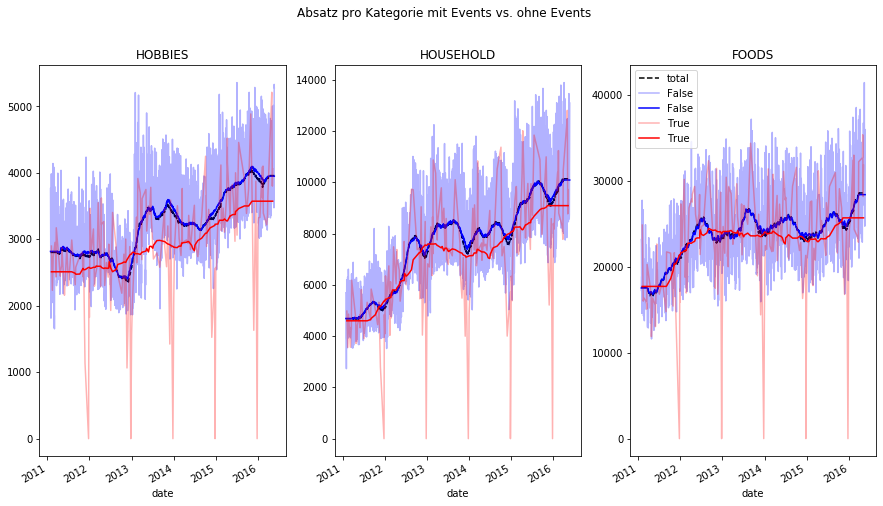

In [ ]:
#from scipy import signal
fig, ax = plt.subplots(1,3, figsize=(15, 8))

i=0
for cat in df['cat_id'].unique():
    sales_cat = df[df['cat_id']==cat].groupby(['date'])['sold'].sum()
    
    clf = KNeighborsRegressor(n_neighbors=100, weights='uniform', n_jobs=4)
    clf.fit(sales_cat.index.values.reshape(-1, 1), sales_cat.values.reshape(-1, 1))
    y_pred = clf.predict(sales_cat.index.values.reshape(-1, 1))
    
    ax[i].plot(sales_cat.index, np.concatenate(y_pred), alpha=1,
             color='black', label = 'total', linestyle='--')
    
    for index, group in df[df['cat_id']==cat].groupby(by=['isEventDay']):
        
        if index:
            n_neighbors = 30
            color = 'red'
        else :
            color = 'blue'
            n_neighbors = 100
            
        clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform', n_jobs=4)
            
        group_agg = group.groupby(['date'])['sold'].sum()
        group_agg.plot(
              alpha=0.3,
              title=cat,
              ax=ax[i], color=color, label = index)
        
        #ax[i].plot(group_agg.index, signal.savgol_filter(group_agg.values, 151, 5), alpha=0.8,
             #color=color)
            
        clf.fit(group_agg.index.values.reshape(-1, 1), group_agg.values.reshape(-1, 1))
        y_pred = clf.predict(group_agg.index.values.reshape(-1, 1))
        ax[i].plot(group_agg.index, np.concatenate(y_pred), alpha=1,
             color=color, label = index)
    
    i = i +1

fig.suptitle('Absatz pro Kategorie mit Events vs. ohne Events')
plt.legend()
plt.show()

## SNAP-Days

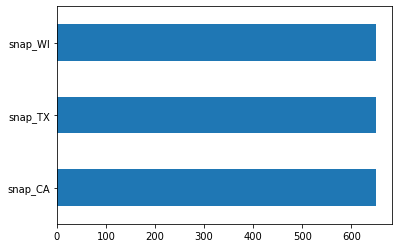

In [ ]:
calendar[['snap_CA', 'snap_TX', 'snap_WI']].sum().plot.barh()

In [ ]:
calendar.groupby('year')[['snap_CA', 'snap_TX', 'snap_WI']].sum()

,snap_CA,snap_TX,snap_WI
year,,,
2011,110,110,110
2012,120,120,120
2013,120,120,120
2014,120,120,120
2015,120,120,120
2016,60,60,60


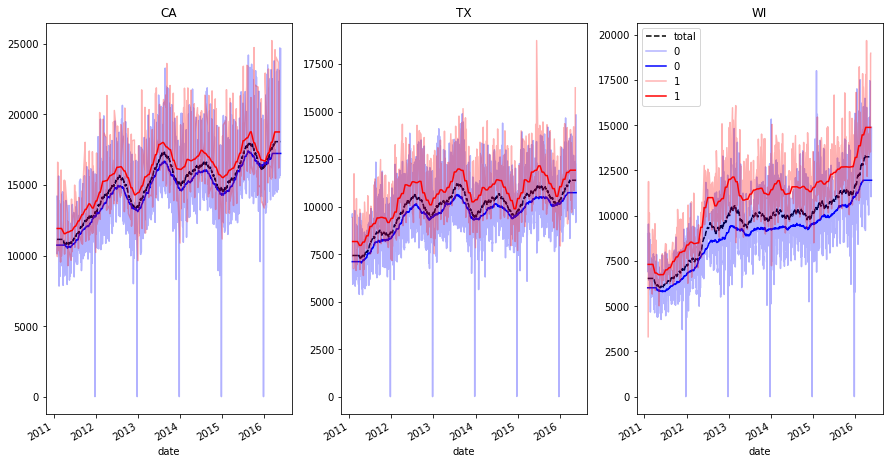

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))

i=0
for state in df['state_id'].unique():
    sales_state = df[df['state_id']==state].groupby(['date'])['sold'].sum()
    
    clf = KNeighborsRegressor(n_neighbors=100, weights='uniform', n_jobs=4)
    clf.fit(sales_state.index.values.reshape(-1, 1), sales_state.values.reshape(-1, 1))
    y_pred = clf.predict(sales_state.index.values.reshape(-1, 1))
    
    ax[i].plot(sales_state.index, np.concatenate(y_pred), 
               alpha=1,
               color='black', 
               label = 'total', 
               linestyle='--')
    
    
    for index, group in df[df['state_id']==state].groupby(by=['snap_' + state]):
        
        if index:
            n_neighbors = 30
            color = 'red'
        else :
            color = 'blue'
            n_neighbors = 100
            
        clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform', n_jobs=4)
            
        group_agg = group.groupby(['date'])['sold'].sum()
        group_agg.plot(
              alpha=0.3,
              title=state,
              ax=ax[i], 
              color=color, 
              label = index)
        
        #ax[i].plot(group_agg.index, signal.savgol_filter(group_agg.values, 151, 5), alpha=0.8,
             #color=color)
            
        clf.fit(group_agg.index.values.reshape(-1, 1), group_agg.values.reshape(-1, 1))
        y_pred = clf.predict(group_agg.index.values.reshape(-1, 1))
        ax[i].plot(group_agg.index, np.concatenate(y_pred), alpha=1,
             color=color, label = index)
        
    i = i +1
plt.legend()
plt.show()

## Preisänderungen

In [ ]:
prices['sell_price'].apply([max, min, np.median])

max       107.312500
min         0.010002
median      3.470703
Name: sell_price, dtype: float64

Die Preise liegen zwischen 0,01 und 107 Dollar. 50 % der Preise liegen unter 3,47 Dollar. 

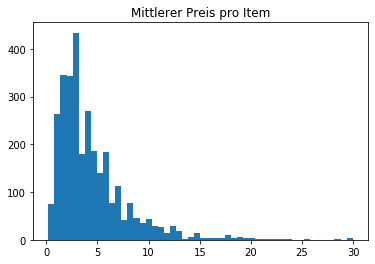

In [ ]:
mean_prices = df.groupby('item_id')['sell_price'].mean()

plt.hist(mean_prices, bins=50)
plt.title('Mittlerer Preis pro Item')
plt.show()

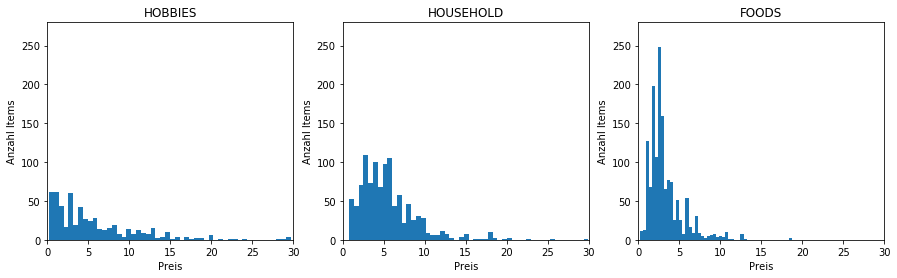

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

i = 0
for cat in df['cat_id'].unique():  
    mean_prices = df[df['cat_id']==cat].groupby('item_id')['sell_price'].mean()

    ax[i].hist(mean_prices, bins=50)
    ax[i].set(title=cat, ylabel='Anzahl Items', xlabel= 'Preis')
    ax[i].set(xlim=[0,30],ylim=[0,280])
    i = i +1
plt.show()

Feld mit Datum zu Integer-Feld umwandeln

In [14]:
df = df.assign(d=df.d.str[2:].astype("int16"))

Kategorien Encoding 

In [15]:
from sklearn.preprocessing import LabelEncoder

nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    df[feature] = df[feature].cat.add_categories('unknown')
    df[feature].fillna('unknown', inplace = True)
        
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id", "event_name_1", "event_name_2", "event_type_1", "event_type_2"]

for feature in cat_id_cols:
    encoder = LabelEncoder()
    df[feature] = encoder.fit_transform(df[feature])
    

Entfernen von nicht benötigten Features

In [ ]:
df.drop(["wm_yr_wk", "weekday","date", "isEventDay" ], axis=1, inplace=True)
downcast(df)

In [ ]:
df.info()

In [ ]:
df = df.assign(id=df.id.str.replace("_validation", ""))

In [ ]:
num_cols = ["sell_price"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI", ]
dense_cols = num_cols + bool_cols

Train and Test Split

In [ ]:
test = df[df.d >= 1914]
valid = df[(df.d < 1914) & (df.d >= 1914 - 28)] 
train =  df[df.d < 1914 - 28] 

In [ ]:
X_train = train.loc[:, (train.columns != 'id') & (train.columns != 'sold')]
y_train = train['sold']

In [ ]:
X_train.head()

In [ ]:
df.info()

In [ ]:
import keras
from keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from keras.models import Model



def create_model(lr=0.002):
    
    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

In [ ]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=valid)